In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

In [27]:
df = pd.read_csv("/content/drive/MyDrive/SML Kaggle/train.csv")
print("Shape:", df.shape)
df.head()

Shape: (1176, 36)


,id,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,VM684,47,Travel_Rarely,1225,Sales,2,4,Life Sciences,1,1676,...,80,3,29,2,3,3,2,1,2,0
1,ZO618,22,Travel_Rarely,594,Research & Development,2,1,Technical Degree,1,169,...,80,1,3,2,3,2,1,2,1,0
2,JO233,46,Travel_Rarely,406,Sales,3,1,Marketing,1,1124,...,80,1,23,3,3,12,9,4,9,0
3,GW565,25,Travel_Rarely,622,Sales,13,1,Medical,1,645,...,80,0,7,1,3,7,4,0,6,0
4,OZ187,43,Travel_Frequently,1001,Research & Development,9,5,Medical,1,663,...,80,1,10,3,3,8,7,4,7,0


In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
#Preprocessing

drop_cols = ["id", "EmployeeCount", "Over18", "StandardHours", "EmployeeNumber", "Gender"]
df = df.drop(columns=drop_cols, errors="ignore")

# Pisahkan fitur dan target
X = df.drop(columns=["Attrition"])
y = df["Attrition"]

# Encoding kategorikal
cat_cols = X.select_dtypes(include="object").columns
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Scaling numerik
num_cols = X.select_dtypes(exclude="object").columns

# cek outlier
num_cols_for_outlier = X_encoded[num_cols].columns
for col in num_cols_for_outlier:
    Q1 = X_encoded[col].quantile(0.25)
    Q3 = X_encoded[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    X_encoded[col] = X_encoded[col].clip(lower=lower_bound, upper=upper_bound)

scaler = StandardScaler()
X_encoded[num_cols] = scaler.fit_transform(X_encoded[num_cols])

In [48]:

# Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, stratify=y, random_state=42
)

In [49]:
#smote balencing
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("Setelah SMOTE:", y_train_res.value_counts())

Setelah SMOTE: Attrition
0    788
1    788
Name: count, dtype: int64


In [50]:
#Model Training dan Tuning

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Logistic Regression
log_reg = LogisticRegression(
    penalty='l2', C=0.7, solver='lbfgs',
    max_iter=3000, class_weight='balanced', random_state=42
)
log_reg.fit(X_train_res, y_train_res)
y_pred_log = log_reg.predict_proba(X_test)[:, 1]
auc_log = roc_auc_score(y_test, y_pred_log)
print(f"\nLogistic Regression (L2 Ridge) - ROC-AUC: {auc_log:.4f}")

# Random Forest (Tuning Cepat)
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_param = {
    'n_estimators': [300, 400, 500],
    'max_depth': [10, 15, 20, None],
    'max_features': ['sqrt', 0.3, 0.5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_tuner = RandomizedSearchCV(
    rf, rf_param, n_iter=10,
    scoring='roc_auc', cv=cv, n_jobs=-1,
    random_state=42, verbose=0
)
rf_tuner.fit(X_train_res, y_train_res)
best_rf = rf_tuner.best_estimator_
y_pred_rf = best_rf.predict_proba(X_test)[:, 1]
auc_rf = roc_auc_score(y_test, y_pred_rf)
print(f"Random Forest (Tuned) - ROC-AUC: {auc_rf:.4f}")

# XGBoost (Tuning Efisien)
xgb = XGBClassifier(
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42,
    scale_pos_weight=(y.value_counts()[0]/y.value_counts()[1])
)
xgb_param = {
    'n_estimators': [400, 500, 600],
    'learning_rate': [0.03, 0.05, 0.07],
    'max_depth': [5, 6, 8],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0.1, 0.2],
    'reg_lambda': [0.5, 1.0]
}
xgb_tuner = RandomizedSearchCV(
    xgb, xgb_param, n_iter=10,
    scoring='roc_auc', cv=cv,
    n_jobs=-1, random_state=42, verbose=0
)
xgb_tuner.fit(X_train_res, y_train_res)
best_xgb = xgb_tuner.best_estimator_
y_pred_xgb = best_xgb.predict_proba(X_test)[:, 1]
auc_xgb = roc_auc_score(y_test, y_pred_xgb)
print(f"XGBoost (Tuned) - ROC-AUC: {auc_xgb:.4f}")

# LightGBM (Cepat dan Efisien)
lgb = LGBMClassifier(
    random_state=42,
    class_weight='balanced'
)
lgb_param = {
    'n_estimators': [300, 400, 500],
    'learning_rate': [0.03, 0.05, 0.07],
    'max_depth': [5, 7, 9],
    'num_leaves': [31, 50, 70],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 1.0],
    'reg_lambda': [0.5, 1.0]
}
lgb_tuner = RandomizedSearchCV(
    lgb, lgb_param, n_iter=10,
    scoring='roc_auc', cv=cv,
    n_jobs=-1, random_state=42, verbose=0
)
lgb_tuner.fit(X_train_res, y_train_res)
best_lgb = lgb_tuner.best_estimator_
y_pred_lgb = best_lgb.predict_proba(X_test)[:, 1]
auc_lgb = roc_auc_score(y_test, y_pred_lgb)
print(f"LightGBM (Tuned) - ROC-AUC: {auc_lgb:.4f}")

# Support Vector Machine (SVM)
svm = SVC(
    kernel='rbf', C=1, gamma='scale',
    probability=True, class_weight='balanced', random_state=42
)
svm.fit(X_train_res, y_train_res)
y_pred_svm = svm.predict_proba(X_test)[:, 1]
auc_svm = roc_auc_score(y_test, y_pred_svm)
print(f"SVM (RBF Kernel) - ROC-AUC: {auc_svm:.4f}")


Logistic Regression (L2 Ridge) - ROC-AUC: 0.8352
Random Forest (Tuned) - ROC-AUC: 0.8268
XGBoost (Tuned) - ROC-AUC: 0.8034
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 788, number of negative: 788
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000687 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5043
[LightGBM] [Info] Number of data points in the train set: 1576, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM (Tuned) - ROC-AUC: 0.7891
SVM (RBF Kernel) - ROC-AUC: 0.7916


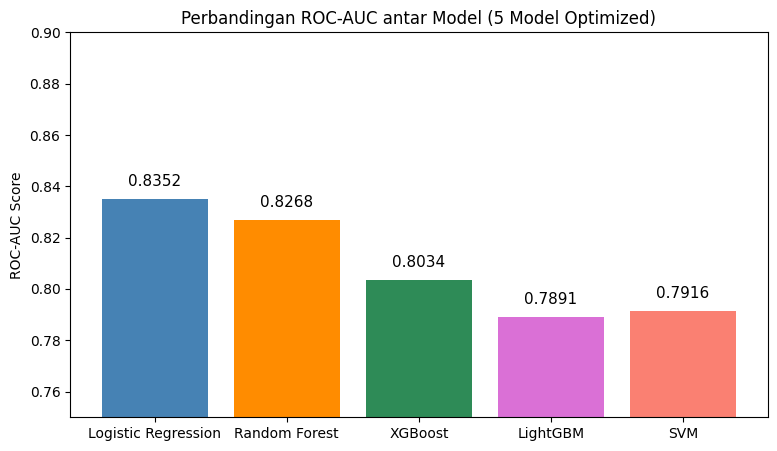

In [51]:
#Evaluasi Perbandingan

model_names = ["Logistic Regression", "Random Forest", "XGBoost", "LightGBM", "SVM"]
auc_scores = [auc_log, auc_rf, auc_xgb, auc_lgb, auc_svm]

plt.figure(figsize=(9,5))
bars = plt.bar(model_names, auc_scores, color=["steelblue", "darkorange", "seagreen", "orchid", "salmon"])
plt.title("Perbandingan ROC-AUC antar Model (5 Model Optimized)")
plt.ylabel("ROC-AUC Score")
plt.ylim(0.75, 0.9)
for bar, score in zip(bars, auc_scores):
    plt.text(bar.get_x() + bar.get_width()/2, score + 0.005, f"{score:.4f}", ha='center', fontsize=11)
plt.show()


In [52]:
# Analisis Hasil

print("\n=== Ringkasan Evaluasi Model ===")
print(f"Logistic Regression (L2 Ridge): {auc_log:.4f}")
print(f"Random Forest (Tuned): {auc_rf:.4f}")
print(f"XGBoost (Tuned): {auc_xgb:.4f}")
print(f"LightGBM (Tuned): {auc_lgb:.4f}")
print(f"SVM (RBF): {auc_svm:.4f}")

best_model_name = model_names[np.argmax(auc_scores)]
print(f"\nModel terbaik berdasarkan ROC-AUC: {best_model_name}")


=== Ringkasan Evaluasi Model ===
Logistic Regression (L2 Ridge): 0.8352
Random Forest (Tuned): 0.8268
XGBoost (Tuned): 0.8034
LightGBM (Tuned): 0.7891
SVM (RBF): 0.7916

Model terbaik berdasarkan ROC-AUC: Logistic Regression


In [54]:
from google.colab import files

test_df = pd.read_csv("/content/drive/MyDrive/SML Kaggle/test.csv")
sample_sub = pd.read_csv("/content/drive/MyDrive/SML Kaggle/sample_submission.csv")
# # Simpan ID untuk submission
test_id = test_df["id"]

# Preprocessing (sama seperti train)
# Drop kolom tidak relevan
drop_cols = ["id", "EmployeeCount", "Over18", "StandardHours", "EmployeeNumber", "Gender"]
test_df = test_df.drop(columns=drop_cols, errors="ignore")

# Encoding kategorikal
cat_cols = test_df.select_dtypes(include="object").columns
test_encoded = pd.get_dummies(test_df, columns=cat_cols, drop_first=True)

# Ensure test_encoded has the new feature engineered columns
if 'YearsAtCompany' in test_encoded.columns and 'JobSatisfaction' in test_encoded.columns:
    test_encoded['YearsAtCompany_JobSat'] = test_encoded['YearsAtCompany'] * test_encoded['JobSatisfaction']
else:
    test_encoded['YearsAtCompany_JobSat'] = 0

if 'Age' in test_encoded.columns:
    test_encoded['Age_Squared'] = test_encoded['Age']**2
else:
    test_encoded['Age_Squared'] = 0

if 'YearsInCurrentRole' in test_encoded.columns and 'YearsAtCompany' in test_encoded.columns:
    test_encoded['RoleTenureRatio'] = test_encoded['YearsInCurrentRole'] / (test_encoded['YearsAtCompany'] + 1e-6)
else:
    test_encoded['RoleTenureRatio'] = 0

for col in X_encoded.columns: # Use X_encoded from after FE for column alignment
    if col not in test_encoded.columns:
        test_encoded[col] = 0

for col in test_encoded.columns:
    if col not in X_encoded.columns:
        test_encoded = test_encoded.drop(columns=col)

test_encoded = test_encoded[X_encoded.columns]
numerical_cols_after_fe = X_encoded.select_dtypes(include=np.number).columns
test_encoded[numerical_cols_after_fe] = scaler.transform(test_encoded[numerical_cols_after_fe])


# Prediksi & Konversi ke Label 0/1

if best_model_name == "Logistic Regression":
    best_model = log_reg
elif best_model_name == "Random Forest":
    best_model = best_rf
elif best_model_name == "XGBoost":
    best_model = best_xgb
elif best_model_name == "LightGBM":
    best_model = best_lgb
elif best_model_name == "SVM":
    best_model = svm
else:

    best_model = log_reg
    print("Warning: Could not identify best model name, defaulting to Logistic Regression.")


test_pred_proba = best_model.predict_proba(test_encoded)[:, 1]
test_pred_label = (test_pred_proba >= 0.5).astype(int)  # threshold 0.5

# Buat Submission Sesuai Format
submission = pd.DataFrame({
    "id": test_id,
    "Attrition": test_pred_label
})

# Tampilkan contoh hasil submission
print(" hasil submission:")
print(submission.head())

 hasil submission:
      id  Attrition
0  CM617          0
1  PJ010          0
2  GJ831          0
3  JD352          0
4  WZ263          1


In [35]:
# ============================================
# 5. Simpan dan Unduh Submission
# ============================================
submission.to_csv("submission.csv", index=False)
files.download("submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [55]:
#Simpan Best Model

import pickle

model_filename = f"{best_model_name.replace(' ', '_')}_model.pkl"
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)

print(f"Model terbaik ({best_model_name}) telah disimpan sebagai {model_filename}")

try:
    from google.colab import files
    files.download(model_filename)
    print(f"File {model_filename} sedang diunduh.")
except ImportError:
    print("Tidak di lingkungan Colab, unduhan file dilewati.")

Model terbaik (Logistic Regression) telah disimpan sebagai Logistic_Regression_model.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File Logistic_Regression_model.pkl sedang diunduh.
